In [1]:
# Import relevant libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.simplefilter('ignore')
plt.style.use('seaborn-notebook')
sns.set_style('darkgrid')
%matplotlib inline

In [ ]:
# Load Data_Entry_2017_v2020.csv
path = './drive/MyDrive/cs109b_final_project/meta_data/'
data_entry_df = pd.read_csv(path + 'Data_Entry_2017_v2020.csv')

# Examine first 5 rows of dataframe
print(f'Shape of data_entry_df: {data_entry_df.shape}')
display(data_entry_df.head())

Shape of data_entry_df: (112120, 11)


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]
0,00000001_000.png,Cardiomegaly,0,1,57,M,PA,2682,2749,0.143,0.143
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168
3,00000002_000.png,No Finding,0,2,80,M,PA,2500,2048,0.171,0.171
4,00000003_001.png,Hernia,0,3,74,F,PA,2500,2048,0.168,0.168


In [ ]:
# Determine the number of unique label combinations
disease_combinations = data_entry_df['Finding Labels'].unique()
print(f'Number of unique disease combinations: {len(disease_combinations)}\n')

# Split up disease_combinations into individual diseases - get number of unique labels
disease_combinations_split = [combination.split('|') for combination in disease_combinations]
diseases = list(set([disease for observation in disease_combinations_split for disease in observation]))

# Sanity check - how many unique diseases are present in the data
print(f'Number of unique diseases (including No Finding): {len(diseases)}\n')
print('Unique diseases (including No Finding): \n')
for disease in diseases:
  print(disease)

Number of unique disease combinations: 836

Number of unique diseases (including No Finding): 15

Unique diseases (including No Finding): 

Cardiomegaly
Pneumothorax
Emphysema
Edema
Pleural_Thickening
Infiltration
Pneumonia
Effusion
Nodule
Fibrosis
Hernia
Mass
No Finding
Atelectasis
Consolidation


In [ ]:
# Limit scope to 8 diseases in original paper
diseases_to_keep = ['Atelectasis', 'Cardiomegaly', 'Effusion',
                    'Infiltration', 'Mass', 'Nodule',
                    'Pneumonia', 'Pneumothorax']
diseases = [disease for disease in diseases if disease in diseases_to_keep]

# Helper function to create one-hot encoded dataframe
@np.vectorize
def one_hot_disease(label, disease='No Finding'):
  if disease in label:
    return 1
  return 0

# Create one-hot encoded dataframe
one_hot_disease_df = data_entry_df[['Image Index']]
for disease in diseases:
  one_hot_disease_df[disease] = one_hot_disease(data_entry_df['Finding Labels'], disease=disease)

# Create column corresponding to the number of observed diseases for a given patient
one_hot_disease_df['n_diseases'] = one_hot_disease_df[diseases].sum(axis=1)

# Save results
# one_hot_disease_df.to_csv(path + 'one_hot_data_entry.csv')

Proportion of healthy patients:
0.5839

Proportion of patients with 1 disease:
0.2778

Proportion of patients with more than 1 disease:
0.1382



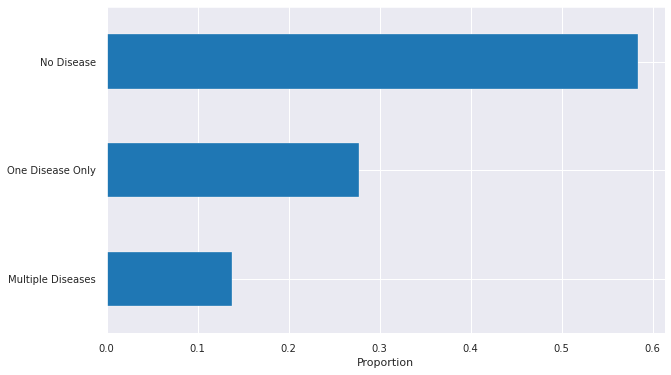

In [ ]:
# How many patients are healthy (no diseases)?
no_disease_prop = (one_hot_disease_df['n_diseases'] == 0).mean()
print('Proportion of healthy patients:')
print(f"{no_disease_prop:.4f}\n")

# How many patients have just one disease?
one_disease_prop = (one_hot_disease_df['n_diseases'] == 1).mean()
print('Proportion of patients with 1 disease:')
print(f"{one_disease_prop:.4f}\n")

# How many patients have multiple diseases?
multi_disease_prop = (one_hot_disease_df['n_diseases'] > 1).mean()
print('Proportion of patients with more than 1 disease:')
print(f"{multi_disease_prop:.4f}\n")

# Visualize the above results
inds = ['No Disease', 'One Disease Only', 'Multiple Diseases']
props = pd.Series(
    data = [no_disease_prop, one_disease_prop, multi_disease_prop],
    index = inds
)

fig, ax = plt.subplots(figsize=(10, 6))

props[::-1].plot(kind = 'barh', ax = ax)

ax.set_xlabel('Proportion');

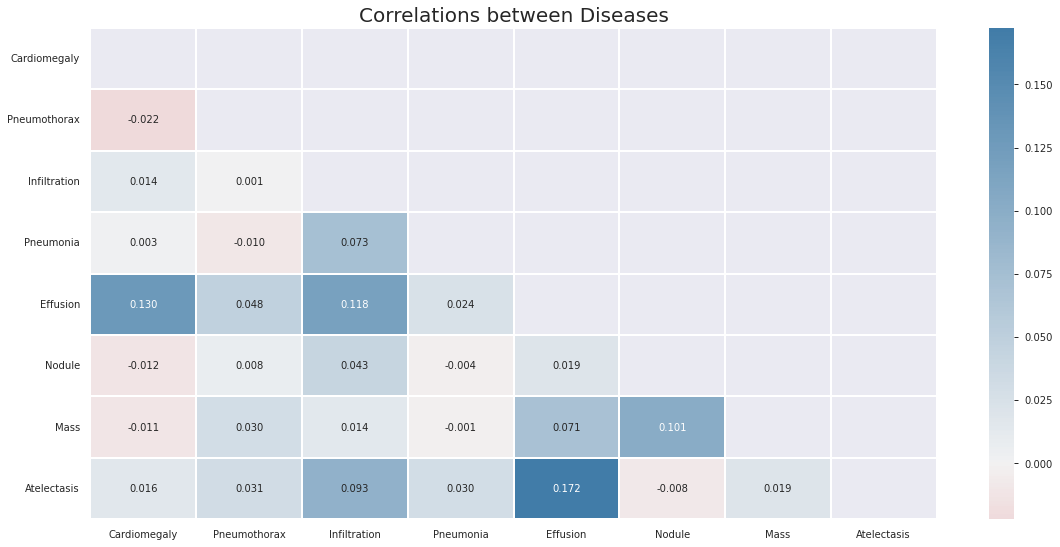

In [ ]:
# Plot heatmap of correlation matrix
corr_mat = one_hot_disease_df[diseases].corr()
bool_mask = np.triu(np.ones_like(corr_mat, dtype=bool))
cmap = sns.diverging_palette(h_neg = 10,
                             h_pos = 240,
                             as_cmap = True)

fig, ax = plt.subplots(figsize=(16, 8))

fig.tight_layout(pad = 3)

sns.heatmap(corr_mat, mask = bool_mask,
            center = 0, cmap = cmap, linewidths = 1,
            annot = True, fmt = '.3f', ax = ax)

ax.set_title('Correlations between Diseases', fontsize=20);

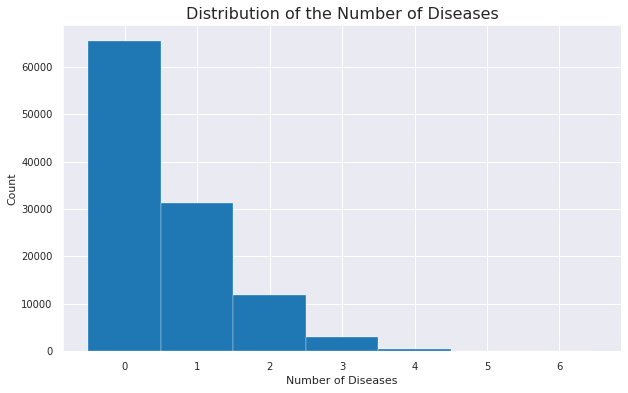

In [ ]:
# What is the distribution of n_diseases?
fig, ax = plt.subplots(figsize=(10, 6))

n_diseases = one_hot_disease_df['n_diseases'].values
bins = np.arange(0, max(n_diseases) + 1.5) - 0.5

ax.hist(n_diseases, bins = bins)

ax.set_xticks([i for i in range(0, max(n_diseases) + 1)])
ax.set_xlabel('Number of Diseases')
ax.set_ylabel('Count')
ax.set_title('Distribution of the Number of Diseases', fontsize=16);

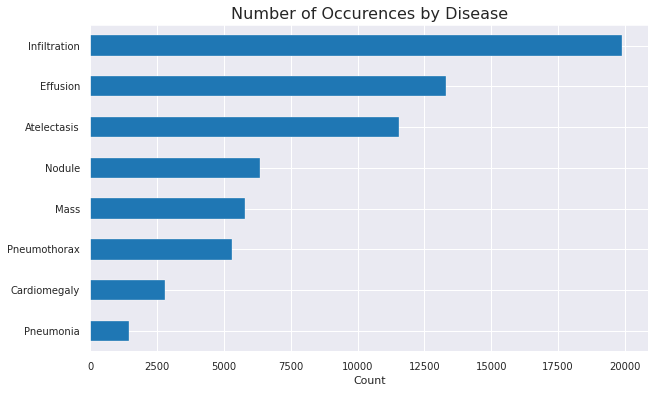

In [ ]:
# What's the most commonly occuring disease?
disease_counts = one_hot_disease_df[diseases].sum(axis = 0).sort_values(ascending = False)

fig, ax = plt.subplots(figsize=(10, 6))

disease_counts[::-1].plot(kind = 'barh', ax = ax)

ax.set_xlabel('Count')
ax.set_title('Number of Occurences by Disease', fontsize = 16);